In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from src.data.loader import load_prices, compute_returns
from outputs.charts.markowitz_plot import plot_efficient_frontier
from src.models.lr import predict_mean_returns
from src.optimization.markowitz import minimize_volatility

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from src.models.lr import evaluate_linear_model, inspect_coefficients

from src.optimization.evaluation import evaluate_portfolio



In [2]:
tickers = ["PETR4.SA", "VALE3.SA", "ITUB4.SA", "BBDC4.SA", "BBAS3.SA", "ABEV3.SA", "WEGE3.SA", "B3SA3.SA", "GGBR4.SA"] # "MGLU3.SA"
start_date = "2017-01-01"
end_date = "2025-06-01"

# Frequência desejada: 'daily', 'weekly', 'monthly', 'annual'
#frequencia_retorno = 'monthly'
#target_return = 0.01
risk_free_rate = 0.15

In [3]:

prices = load_prices(tickers, start=start_date, end=end_date)

returns_daily = compute_returns(prices, freq='daily')
returns_monthly = compute_returns(prices, freq='monthly')
returns_annually = compute_returns(prices, freq='annually')

mean_returns_daily = returns_daily.mean()
cov_matrix_daily = returns_daily.cov()

mean_returns_monthly = returns_monthly.mean()
cov_matrix_monthly = returns_monthly.cov()

mean_returns_annually = returns_annually.mean()
cov_matrix_annually = returns_annually.cov()

/workspaces/deep_learning_finance/src/data/loader.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start, end=end)['Close']


[*********************100%***********************]  9 of 9 completed


In [4]:
prices.shape

(2094, 9)

(9,) (2094, 9)
Retornos esperados (Regressão Linear):
ABEV3.SA   -0.000814
B3SA3.SA   -0.000967
BBAS3.SA   -0.001241
BBDC4.SA    0.002064
GGBR4.SA   -0.000693
ITUB4.SA    0.000489
PETR4.SA   -0.000897
VALE3.SA   -0.001157
WEGE3.SA   -0.000940
Name: Predicted_Mean_Returns, dtype: float64


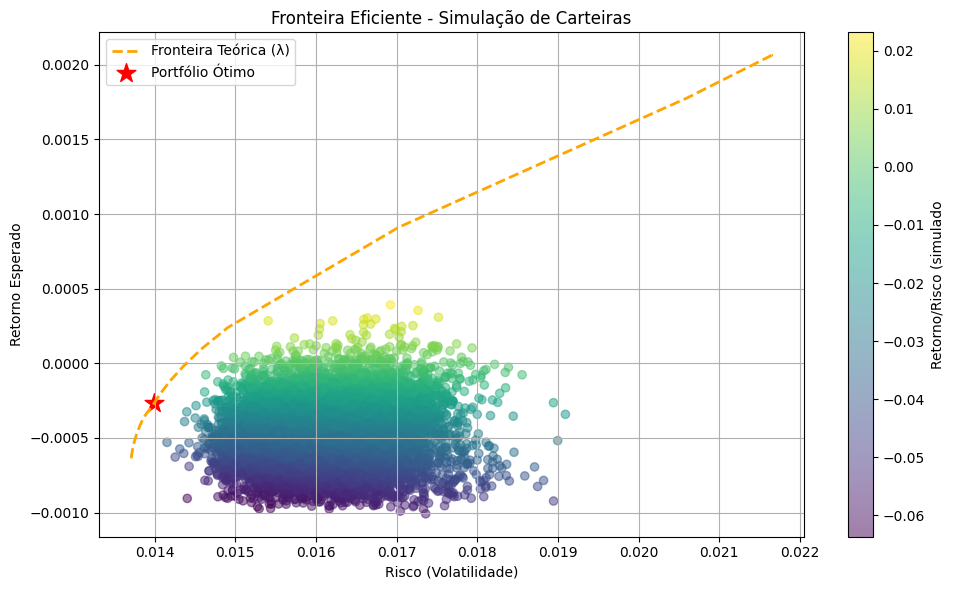

In [5]:


# Prever retornos esperados via regressão linear
from src.optimization.markowitz import solve_markowitz


predicted_means = predict_mean_returns(prices, window=5)
print(predicted_means.shape, prices.shape)

print("Retornos esperados (Regressão Linear):")
print(predicted_means)

# Substituir as médias históricas
mean_returns_pred = predicted_means

# Continuar normalmente com Markowitz

#weights_pred = minimize_volatility(mean_returns_pred, cov_matrix_daily)
weights_pred = solve_markowitz(mean_returns_pred, cov_matrix_daily, 0.5)

plot_efficient_frontier(mean_returns_pred, cov_matrix_daily, optimized_weights=weights_pred)
#mas por que eu estou usando esse returns_daily como parametro se o modelo propor a criar um retorno medio, sendo o predicted_means = predict_mean_returns(prices, window=5)? mean_returns_pred = predicted_means


In [6]:
predicted_means

ABEV3.SA   -0.000814
B3SA3.SA   -0.000967
BBAS3.SA   -0.001241
BBDC4.SA    0.002064
GGBR4.SA   -0.000693
ITUB4.SA    0.000489
PETR4.SA   -0.000897
VALE3.SA   -0.001157
WEGE3.SA   -0.000940
Name: Predicted_Mean_Returns, dtype: float64

In [7]:
eval_results = evaluate_linear_model(prices, window=5)
print(eval_results)

     Ticker       MSE        R²  Correlação
0  ABEV3.SA  0.000141  0.223843    0.482681
1  B3SA3.SA  0.000359  0.132400    0.399228
2  BBAS3.SA  0.000157  0.125902    0.393163
3  BBDC4.SA  0.000268  0.202254    0.459903
4  GGBR4.SA  0.000263  0.177134    0.437539
5  ITUB4.SA  0.000130  0.144974    0.419103
6  PETR4.SA  0.000212  0.197502    0.494778
7  VALE3.SA  0.000179  0.182902    0.454660
8  WEGE3.SA  0.000243  0.262054    0.512428


In [8]:
coefs = inspect_coefficients(prices, window=5)
print(coefs.head(10))

                 ABEV3.SA  B3SA3.SA  BBAS3.SA  BBDC4.SA  GGBR4.SA  ITUB4.SA  \
ABEV3.SA_lag1   -0.004840 -0.000821 -0.001864 -0.001529 -0.002325 -0.000662   
ABEV3.SA_mean_5  0.009331 -0.000034  0.000411  0.000290  0.000589 -0.000364   
ABEV3.SA_std_5   0.000160  0.000027 -0.000415 -0.000565 -0.000097 -0.000425   
B3SA3.SA_lag1   -0.000047 -0.006315 -0.000402 -0.000315 -0.000146 -0.000469   
B3SA3.SA_mean_5  0.000007  0.013452  0.000753  0.000017  0.001755  0.000826   
B3SA3.SA_std_5   0.000492 -0.000208  0.000977  0.001184 -0.000111  0.000801   
BBAS3.SA_lag1   -0.000610  0.000437 -0.005426 -0.000192  0.000379 -0.000055   
BBAS3.SA_mean_5  0.000028 -0.001647  0.011400 -0.000653 -0.000421 -0.000690   
BBAS3.SA_std_5   0.000496 -0.000509  0.000482 -0.000488  0.000064  0.000257   
BBDC4.SA_lag1   -0.000845  0.000516  0.001621 -0.004777  0.000180  0.001174   

                 PETR4.SA  VALE3.SA  WEGE3.SA  
ABEV3.SA_lag1   -0.002900 -0.002769 -0.000292  
ABEV3.SA_mean_5  0.000628  0.00138

In [9]:

results_linear = evaluate_portfolio(
    returns=returns_daily,
    weights=weights_pred,
    freq='daily',
    model_name='linear_metrics',
)

pd.DataFrame([results_linear]).to_csv("../outputs/models/linear_metrics.csv", index=False)


In [10]:
df_pesos = pd.DataFrame({
    "Ticker": tickers,
    "Peso Markowitz LR": weights_pred,
})
print(df_pesos.sort_values("Peso Markowitz LR", ascending=False).round(4))

     Ticker  Peso Markowitz LR
0  PETR4.SA             0.3167
8  GGBR4.SA             0.2147
5  ABEV3.SA             0.1753
7  B3SA3.SA             0.1542
3  BBDC4.SA             0.1390
1  VALE3.SA             0.0000
4  BBAS3.SA             0.0000
2  ITUB4.SA             0.0000
6  WEGE3.SA             0.0000
